# Installs & imports

In [4]:
import os

import torch

os.environ["TORCH"] = torch.__version__
print(torch.__version__)


!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 22.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
!pip install omegaconf einops open3d class_resolver
!pip install hausdorff
!pip install gcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.4 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=7f13dd3d3563129397bc5a5c8344dc98fd739c66197b5e4a2df8d39fc69cc595
  Stored in directory: /root/.cache/pip/wheels/1

  Preparing metadata (setup.py) ... done
  Created wheel for hausdorff: filename=hausdorff-0.2.6-py3-none-any.whl size=15187 sha256=a239600852bc4b2f292283c973f92644307f513f876d66b5828e69ff4d01734a
  Stored in directory: /root/.cache/pip/wheels/cd/9e/ee/d7c81175a113c77a1169316da33a6491b29920365dc001256a
Successfully built hausdorff


In [60]:

from datetime import datetime

# utils
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric
from torch_geometric.utils import to_dense_batch
import open3d as o3d
from tqdm.notebook import tqdm, trange
import pandas as pd

import sys

from utils.data import load_xyz_file
from utils.losses import chamfer_dist_repulsion, density_chamfer_dist, chamfer_distance
from utils.viz import (
    draw_point_cloud,
    point_cloud_three_views,
    viz_many,
    viz_many_mpl,
    viz_pcd_graph,
)
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from pugcn_lib.models import JustUpsample, PUGCN, PUInceptionTransformer

# Input Parameters (folder paths...)

In [25]:
input_dir = os.path.join("data", "PU1K", "test", "kenki") #input dataのパス。格"argument"がフォルダー名
#gt_dir = os.path.join("data", "PU1K", "test", "input_2048", "gt_8192") #ground truthと比較する場合uncommentして、そのデータの記載
results_dir = os.path.join("data", "results") #結果が保存される場所

In [10]:
sorted(os.listdir("trained-models/")) #ckpt＿xxxxっていうcheckpointファイルが保存されたフォルダーのパス
ckpt_dir = "2023-11-27-16-56-pugcn-baseline" #使いたいtrain済みモデル
ckpt_name = "ckpt_epoch_10" #説明むず。学習中何回かモデルが保存される。Trainingの時設定したepoch数に関係ある
ckpt_dir

'2023-11-27-16-56-pugcn-baseline'

# Load model

Load a model from checkpoint and evaluate with it trained-modelsフォルダーーの名前変更してたら気をつけて

In [13]:
os.listdir(os.path.join("trained-models", ckpt_dir)) #ここもpathあってるか注意

['config.yaml', 'ckpt_epoch_1', 'ckpt_epoch_5', 'ckpt_epoch_10']

In [14]:
exp_conf = OmegaConf.load(os.path.join("trained-models", ckpt_dir, "config.yaml"))
print(exp_conf)

{'name': 'pugcn-baseline', 'model_config': {'r': 4, 'k': 16, 'dilations': [1, 2, 4], 'n_idgcn_blocks': 3, 'channels': 64, 'n_dgcn_blocks': 3, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'conv': 'edge', 'pool_type': 'mean', 'dynamic': False, 'use_refiner': False, 'upsampler': 'nodeshuffle', 'hierarchical': False}, 'train_config': {'batch_size': 64, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'augment': True, 'loss_fn': 'cd', 'k_loss': 4}, 'data_config': {'path': '../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 1, 'use_randominput': True, 'rng_seed': 42}}


In [17]:
#gpuやcudaあるかないかによる、適当にcomment/uncommentしちゃって
checkpoint = torch.load(os.path.join("trained-models", ckpt_dir, ckpt_name)) #gpu version
#checkpoint = torch.load(os.path.join("trained-models", ckpt_dir, ckpt_name), map_location=torch.device('cpu')) #cpu version

In [18]:
history = OmegaConf.create(checkpoint["history"])

In [19]:
#plt.plot(history.train_loss) #train lossのグラフ興味ある人、uncommentして

In [20]:
model_config = exp_conf.model_config

In [21]:
model_config

{'r': 4, 'k': 16, 'dilations': [1, 2, 4], 'n_idgcn_blocks': 3, 'channels': 64, 'n_dgcn_blocks': 3, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'conv': 'edge', 'pool_type': 'mean', 'dynamic': False, 'use_refiner': False, 'upsampler': 'nodeshuffle', 'hierarchical': False}

In [22]:
 model = PUGCN(**model_config) #学習したモデルのbase architecture適当にcomment/uncommentして
# model = PUInceptionTransformer(**model_config)
#model = JustUpsample(**model_config)

In [23]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

# Upsamplig Vizualisation (single file)

In [26]:
file = "test5data" + ".xyz"
data = load_xyz_file(os.path.join(input_dir, file))
#gt = load_xyz_file(os.path.join(gt_dir, file))
data = torch.tensor(data, dtype=torch.float32)
#gt = torch.tensor(gt, dtype=torch.float32)

In [33]:
out = model(data).detach()

In [36]:
out_df = pd.DataFrame(out.numpy()) #dataframeに変換
out_df.to_csv(os.path.join(results_dir,file))

In [38]:
# o3d　#かっこいい3次元vizualisation
#viz_many([data.numpy(), gt.numpy(), out.numpy()])　#ground truthがある場合
# o3d
viz_many([data.numpy(), out.numpy()])

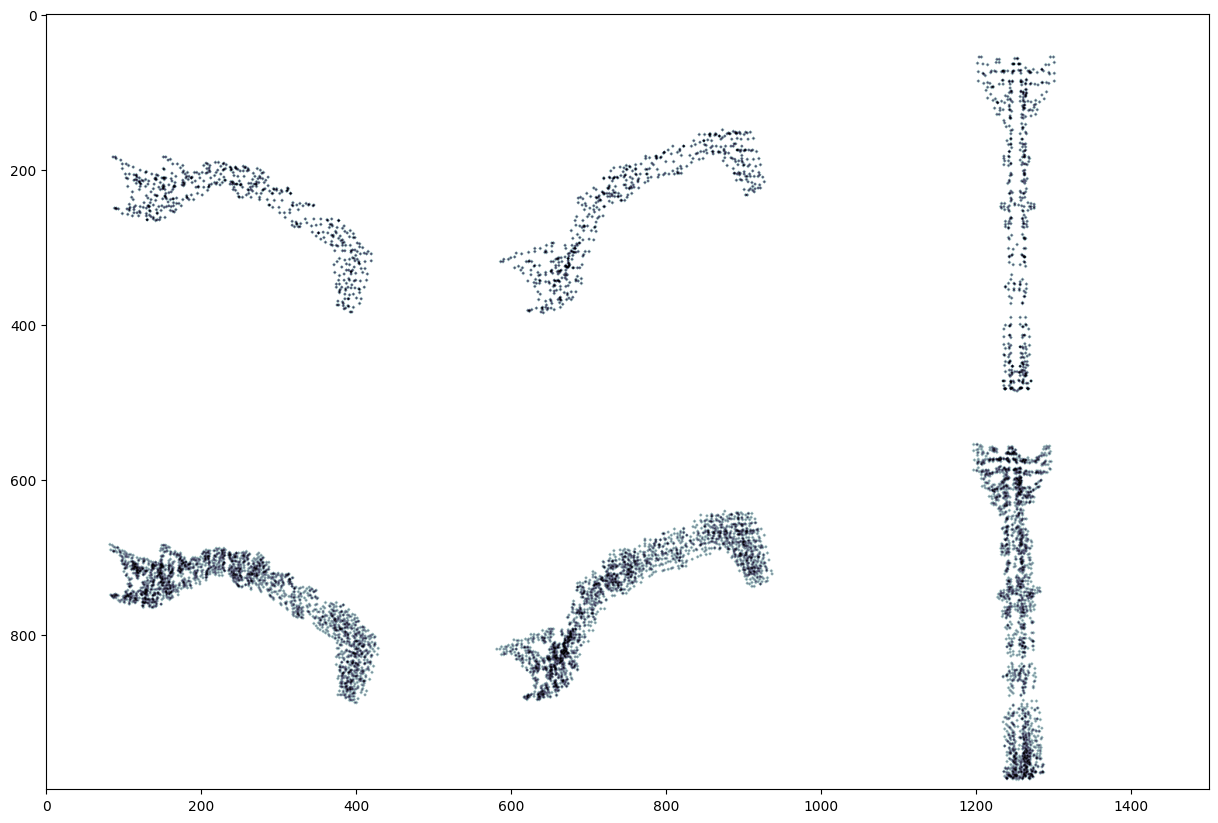

In [42]:
fig = plt.figure(figsize=(15, 15))
img_data = point_cloud_three_views(data.numpy())
#img_gt = point_cloud_three_views(gt.numpy())
img_out = point_cloud_three_views(out.numpy())
plt.imshow(np.concatenate([img_data,img_out]), cmap="bone") #cmap好きです

In [ ]:
# v.capture_screen_image("test.png") #画像を保存する

# Loop upsampling for all files in Folder

In [ ]:
directory = os.fsencode(input_dir)

for file in os.listdir(input_dir):
     data = load_xyz_file(os.path.join(input_dir, file))
     #gt = load_xyz_file(os.path.join(gt_dir, file))
     data = torch.tensor(data, dtype=torch.float32)
     #gt = torch.tensor(gt, dtype=torch.float32)
     out = model(data).detach()
     out_df = pd.DataFrame(out.numpy()) #dataframeに変換
     out_df.to_csv(os.path.join(results_dir,file))